In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dm_control import suite, viewer
from tqdm import tqdm
from simulation.dm_control.ddpg.ddpg_classes.ddpg import DDPGagent, OUNoise
from simulation.dm_control.ddpg.ddpg_classes.utils import MemoryRank

In [2]:
random_state = np.random.RandomState(42)

RESUME_TRAINING = False
PATH_MODEL = 'cartpole'
TASK = 'balance'
NUM_EPISODES = 100
BATCH_SIZE = 128
DURATION = 50
ACTOR_LEARNING_RATE=1e-4
CRITIC_LEARNING_RATE=1e-3
GAMMA=0.99
TAU=1e-2

env = suite.load(PATH_MODEL, TASK, task_kwargs={'random': random_state})
action_spec = env.action_spec()
obs_spec = env.observation_spec()
dim_action = action_spec.shape[0]
dim_obs = sum(tuple(map(lambda x: int(np.prod(x.shape)), obs_spec.values())))

agent = DDPGagent(
    dim_obs,
    dim_action,
    actor_learning_rate=ACTOR_LEARNING_RATE,
    critic_learning_rate=CRITIC_LEARNING_RATE,
    gamma=GAMMA,
    tau=TAU,
    memory=MemoryRank
)
if RESUME_TRAINING: agent.load(PATH_MODEL)
noise = OUNoise(dim_action, action_spec.minimum, action_spec.maximum)

def denorm(a): #  use on model output before passing to env
    act_k = (action_spec.maximum - action_spec.minimum) / 2.
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return a * act_k + act_b

def norm(a): # use on env output before passing to model
    act_k_inv = 2. / (action_spec.maximum - action_spec.minimum)
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return act_k_inv * (a - act_b)

def parse(obs):
    """
    We lose information about the variables when we combine, for instance,
    velocity and position into 1 long array of observations. Could treating
    them separately lead to a better NN architecture? Velocity, position
    and numerical integration for instance take only ...
    """
    x = np.array([])
    for _, v in obs.items():
        x = np.append(x, v)
    return x

def off_policy():
    return np.random.uniform(action_spec.minimum, action_spec.maximum, size=action_spec.shape)

  0%|          | 0/100 [00:00<?, ?it/s]/home/ivin/Cambridge University Robotics/cur_policy_learning_research/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ivin/Cambridge University Robotics/cur_policy_learning_research/venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 100/100 [00:28<00:00,  3.46it/s]


episode: 0, reward: 47.21, average_reward: nan
episode: 1, reward: 36.81, average_reward: 47.21072281430339
episode: 2, reward: 47.4, average_reward: 42.011772913099435
episode: 3, reward: 43.14, average_reward: 43.808654136281774
episode: 4, reward: 47.13, average_reward: 43.6410939276502
episode: 5, reward: 48.5, average_reward: 44.33876523400894
episode: 6, reward: 44.51, average_reward: 45.03226971275546
episode: 7, reward: 45.98, average_reward: 44.958252914412064
episode: 8, reward: 45.59, average_reward: 45.08577684334368
episode: 9, reward: 42.74, average_reward: 45.142062895632925
episode: 10, reward: 37.92, average_reward: 44.901552069002335
episode: 11, reward: 44.94, average_reward: 43.972210498018896
episode: 12, reward: 40.71, average_reward: 44.78525902408317
episode: 13, reward: 42.56, average_reward: 44.11607118702279
episode: 14, reward: 47.87, average_reward: 44.0583938398708
episode: 15, reward: 35.39, average_reward: 44.13233840994444
episode: 16, reward: 37.12, av

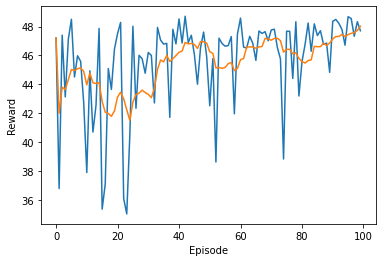

In [3]:
rewards = []
avg_rewards = []

for episode in tqdm(range(NUM_EPISODES)):
    time_step = env.reset()
    state = parse(time_step.observation)
    noise.reset()
    episode_reward = 0

    for step in range(DURATION):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        time_step_2 = env.step(denorm(action))
        state_2 = parse(time_step_2.observation)
        agent.memory.push(state, action, time_step_2.reward, state_2, -1)
        state = state_2
        if len(agent.memory) > BATCH_SIZE:
            agent.update(BATCH_SIZE)
        episode_reward += time_step_2.reward
    print(f"episode: {episode}, "
      f"reward: {np.round(episode_reward, decimals=2)}, "
      f"average_reward: {np.mean(rewards[-10:])}")
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

agent.save(PATH_MODEL)

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [5]:
# Define a uniform random policy.
t = -1
def policy(time_step):
    global t
    t += 1
    state = parse(time_step.observation)
    action = agent.get_action(state)
    # print(time_step)
    action = noise.get_action(action, t)
    action = denorm(action)
    # print(action)
    return action

# Launch the viewer application.
viewer.launch(env, policy=policy)